experiment configs

In [1]:
from dataclasses import dataclass

@dataclass
class ExperimentConfig:
    real_A: bool

config = ExperimentConfig(real_A=True)

utils

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import misc
import itertools
from datasets import load_dataset
from skimage.metrics import structural_similarity as ssim
from numpy import linalg as LA

dataset = load_dataset("mnist")

# Load one of the example images from scipy
example_image = np.array(dataset["train"][1]["image"])
example_image_resized = cv2.resize(example_image, (7, 7))
example_image_resized = example_image_resized / (255.0)

# Get the dimensions of the resized image
h, w = example_image_resized.shape

# Set oversampling factor
oversampling_factor = 2

# Generate the matrix A
n = w * h  # n is based on the width * height of the resized image

# Generate oversampled FFT matrix with zero-padding
# reconstruct the matrix corresponding to the oversampled FFT operation
# which will have size (n*oversampling_factor^2)xn
A = np.zeros((oversampling_factor**2 * n, n), dtype=complex)
for j in range(n):
    basis_vector = np.zeros(n)
    basis_vector[j] = 1
    
    # get the FFT of the basis vector
    basis_vector_fft = np.fft.fft2(basis_vector.reshape((h, w)), (oversampling_factor * h, oversampling_factor * w), norm="ortho")
    A[:, j] = basis_vector_fft.flatten()
if config.real_A:
    A.imag = 0

# Apply oversampled FFT to the resized example image
# y = np.abs(np.fft.fft2(example_image_resized, (oversampling_factor * h, oversampling_factor * w), norm="ortho"))**2
y = np.abs(A @ example_image_resized.reshape(-1, 1))**2

# A_func = lambda x: np.fft.fft2(x.reshape((h, w)), (oversampling_factor * h, oversampling_factor * w), norm="ortho")
# Ainv_func = lambda x: np.fft.ifft2(x.reshape((oversampling_factor * h, oversampling_factor * w)), norm="ortho")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def polar_convert(b,p):
    r = b * np.cos(p)
    im = b * np.sin(p)
    return (r + 1j* im)

In [4]:
import numpy as np
from scipy.ndimage import shift
from sklearn.metrics import mean_squared_error

def find_optimal_shift(target, B):
    best_shift = (0,0)
    min_mse = 9999

    for (i, j) in itertools.product(range(target.shape[0]), range(target.shape[1])):  # considering all possible circular shifts
        shifted_B = np.roll(B, shift=(i, j), axis=(0, 1))
        mse = mean_squared_error(target.flatten(), shifted_B.flatten())
        if mse < min_mse:
            min_mse = mse
            best_shift = (i, j)

    # Apply the optimal shift to array B
    optimal_shifted_B = np.roll(B, shift=best_shift, axis=(0, 1))
    return optimal_shifted_B

In [5]:
def compare_images(example_image_resized_, reconstructed_image_, method):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Image Comparison for {method} Method')  # Added suptitle
    plt.subplot(1, 2, 1), plt.imshow(example_image_resized_, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 2, 2), plt.imshow(reconstructed_image_, cmap='gray'), plt.title('Reconstruction')
    plt.show()

    correlation = np.corrcoef(example_image_resized_.flatten(), reconstructed_image_.flatten())[0, 1]
    print(f'Correlation between the original image and reconstruction: {correlation}')
    # MSE
    mse = np.mean((example_image_resized_.flatten() - reconstructed_image_.flatten())**2)
    print(f'MSE between the original image and reconstruction: {mse}')
    # PSNR
    psnr = 10 * np.log10(1 / mse)
    print(f'PSNR between the original image and reconstruction: {psnr}')
    # SSIM
    ssim_ = ssim(example_image_resized_, reconstructed_image_)
    print(f'SSIM between the original image and reconstruction: {ssim_}')

phaselift

In [36]:
def phaselift(W, A_, y_):
    X = cp.Variable((n, n), symmetric=True)
    objective = cp.Minimize(cp.trace(W @ X))
    constraints = [X >> 0]
    constraints += [
        y_[i] == A_[i, :].reshape(1, -1).conj() @ X @ A_[i, :].reshape(-1, 1)
        for i in range(y_.shape[0])
    ]
    # constraints += [
    #     y_[i] == cp.trace(A_[i, :].reshape(-1, 1) @ A_[i, :].reshape(1, -1).conj() @ X)
    #     for i in range(y_.shape[0])
    # ]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=True, mosek_params={'MSK_IPAR_INTPNT_SOLVE_FORM': 'MSK_SOLVE_DUAL'})
    return X.value
    
def iterative_phaselift(A_, y_, k, eps):
    W = np.eye(n)
    for i in range(k):
        X = phaselift(W, A_, y_)
        _, V = LA.eigh(X)
        W = np.linalg.inv(X+eps*np.eye(n))
    return(X)

In [37]:
X = iterative_phaselift(A, y, 4, 0.001)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 23 07:13:55 PM: Your problem has 2401 variables, 197 constraints, and 0 parameters.
(CVXPY) Dec 23 07:13:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 23 07:13:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 23 07:13:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


(CVXPY) Dec 23 07:13:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 23 07:13:55 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 23 07:13:55 PM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Dec 23 07:13:55 PM: Applying reduction Complex2Real
(CVXPY) Dec 23 07:13:55 PM: Applying reduction Dcp2Cone
(CVXPY) Dec 23 07:13:55 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 23 07:13:55 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Dec 23 07:13:56 PM: Applying reduction MOSEK
(CVXPY) Dec 23 07:13:56 PM: Finished problem compilation (took 8.683e-01 seconds).
-------------------------------------------------------------------------------
                    

In [38]:
# Get the eigenvector corresponding to the largest eigenvalue
S, V = LA.eigh(X)
largest_eigenvector = V[:, -1] * np.sqrt(S[-1])

# Reshape the eigenvector to the original image size
reconstructed_image = np.abs(np.reshape(largest_eigenvector, example_image_resized.shape))

reconstructed_image_phaselift = find_optimal_shift(example_image_resized, reconstructed_image)

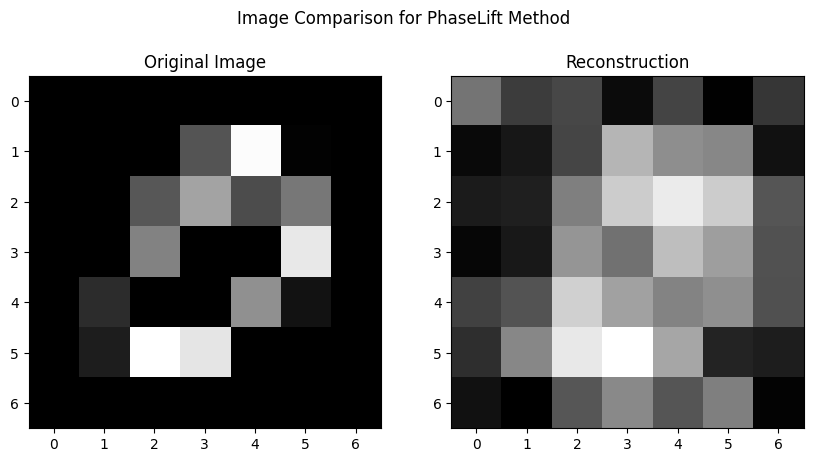

Correlation between the original image and reconstruction: 0.6190476318958797
MSE between the original image and reconstruction: 0.05172774977487903
PSNR between the original image and reconstruction: 12.862764135609314
SSIM between the original image and reconstruction: 0.463639413969753


In [39]:
compare_images(example_image_resized, reconstructed_image_phaselift, "PhaseLift")

phasecut

In [10]:
def phasecut(b, A_n):
    m = b.shape[0]
    X = cp.Variable((m,m), hermitian=True)
    M = np.diag(b.flatten()) @ (np.identity(A_n.shape[0]) - A_n @ LA.pinv(A_n)) @ np.diag(b.flatten())

    obj = cp.real(cp.trace(X @ M))
    constr = [X >> 0]
    constr += [cp.diag(X) == np.ones(m,)]
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve(solver=cp.MOSEK, verbose=True, mosek_params={'MSK_IPAR_INTPNT_SOLVE_FORM': 'MSK_SOLVE_DUAL'})
    
    return X.value

In [11]:
b = np.sqrt(y)
X = phasecut(b, A)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 23 07:05:57 PM: Your problem has 38416 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 23 07:05:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 23 07:05:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 23 07:05:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 23 07:05:57 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 23 07:05:57 PM: Compiling problem (target solver=MOSEK).


In [12]:
# Get the eigenvector corresponding to the largest eigenvalue
S, V = LA.eigh(X)
largest_eigenvector = V[:, -1] / np.abs(V[:, -1])

# Reshape the eigenvector to the original image size
reconstructed_image = b.flatten() * largest_eigenvector
reconstructed_image = LA.pinv(A) @ reconstructed_image
reconstructed_image = np.abs(np.reshape(reconstructed_image, np.array(example_image_resized.shape)))

reconstructed_image_phasecut = find_optimal_shift(example_image_resized, reconstructed_image)

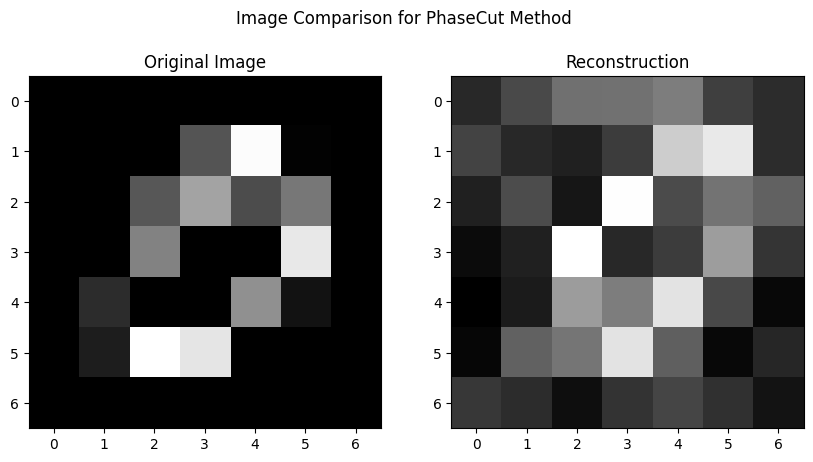

Correlation between the original image and reconstruction: 0.6341892116565317
MSE between the original image and reconstruction: 0.054210836751540724
PSNR between the original image and reconstruction: 12.659138892740579
SSIM between the original image and reconstruction: 0.5404382151606743


In [13]:
compare_images(example_image_resized, reconstructed_image_phasecut, "PhaseCut")

phasemax

In [14]:
def phasemax(b, A_n):
    m, n = A_n.shape
    xhat = np.random.rand(n)
    
    for _ in range(80):
        x = cp.Variable(n, complex=True)
        
        constr = [cp.abs(A_n @ x) <= b.flatten()]
        obj = cp.real(xhat.conj().T @ x)
        prob = cp.Problem(cp.Maximize(obj), constr)
        prob.solve()

        xhat = x.value
        
    return xhat

In [15]:
b = np.sqrt(y)
X = phasemax(b, A)

In [16]:
reconstructed_image = np.abs(np.reshape(X, np.array(example_image_resized.shape)))

reconstructed_image_phasemax = find_optimal_shift(example_image_resized, reconstructed_image)

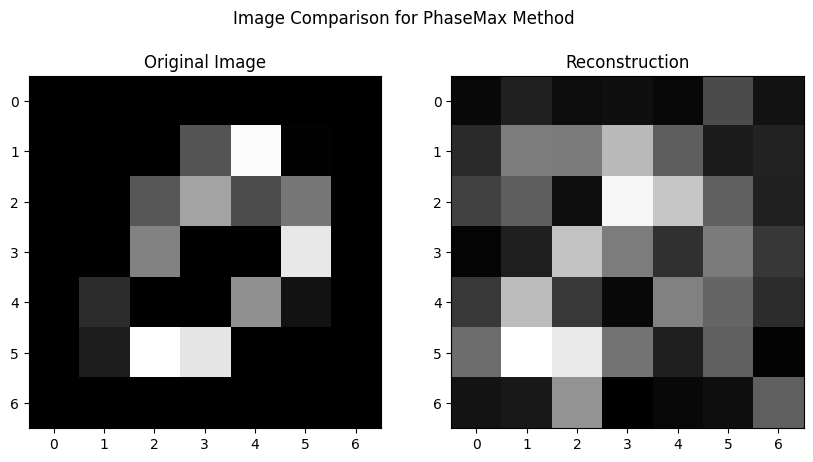

Correlation between the original image and reconstruction: 0.5451938939912021
MSE between the original image and reconstruction: 0.06084084043056611
PSNR between the original image and reconstruction: 12.158047954106838
SSIM between the original image and reconstruction: 0.4783274806932653


In [17]:
compare_images(example_image_resized, reconstructed_image_phasemax, "PhaseMax")

phasemax (dual)

In [18]:
def dual_phasemax(b, A_n):
    m, n = A_n.shape
    xhat = np.random.rand(n)
    
    for _ in range(80):
        z = cp.Variable(m, complex=True)
        B = np.diag(b.flatten())
        constr = [xhat == A_n.conj().T @ LA.inv(B) @ z]
        obj = cp.norm(z, 1)
        prob = cp.Problem(cp.Minimize(obj), constr)
        prob.solve()
        
        xhat = np.abs(LA.pinv(A_n) @ polar_convert(b.flatten(), np.angle(z.value)))
    return xhat

In [19]:
b = np.sqrt(y)
X = dual_phasemax(b, A)

In [20]:
reconstructed_image = np.abs(np.reshape(X, np.array(example_image_resized.shape)))

reconstructed_image_phasemaxdual = find_optimal_shift(example_image_resized, reconstructed_image)

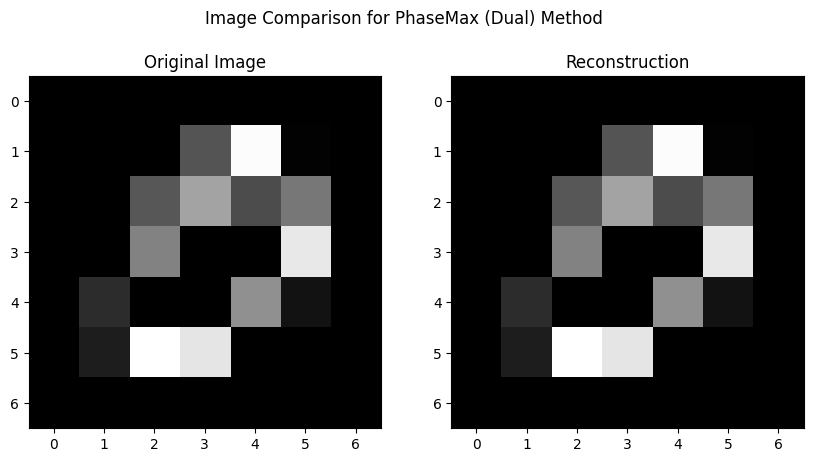

Correlation between the original image and reconstruction: 1.0
MSE between the original image and reconstruction: 1.0287423969616588e-31
PSNR between the original image and reconstruction: 309.8769336147085
SSIM between the original image and reconstruction: 1.0


In [21]:
compare_images(example_image_resized, reconstructed_image_phasemaxdual, "PhaseMax (Dual)")

compare different methods

In [22]:
def compare_different_methods(**kwargs):
    plt.figure(figsize=(15, 4))
    plt.suptitle('Qualitative Comparison for Different Methods')  # Added suptitle
    N = len(kwargs)
    for i, (method, image) in enumerate(kwargs.items()):
        plt.subplot(1, N, i+1), plt.imshow(image, cmap='gray'), plt.title(method)
    plt.show()

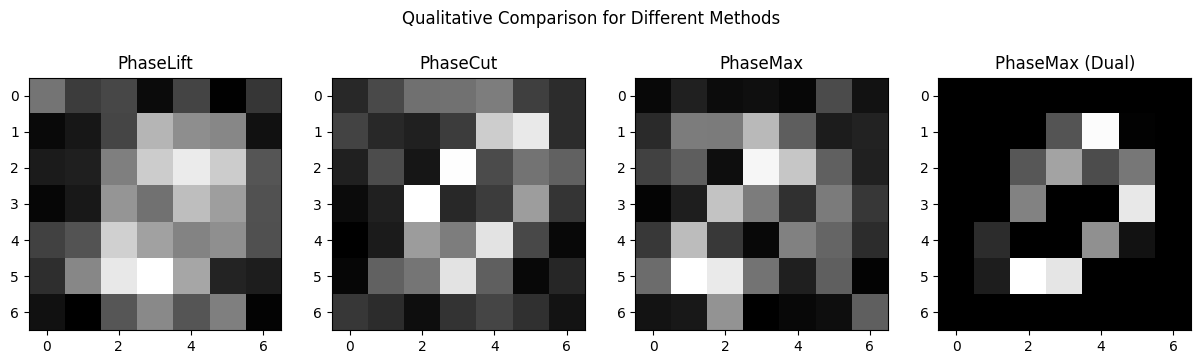

In [42]:
methodname_image_dict = {
    "PhaseLift": reconstructed_image_phaselift,
    "PhaseCut": reconstructed_image_phasecut,
    "PhaseMax": reconstructed_image_phasemax,
    "PhaseMax (Dual)": reconstructed_image_phasemaxdual,
}

compare_different_methods(**methodname_image_dict)